__Non Linear Search__

In this example, we're going to find a lens model that provides a good fit to an image, without assuming any knowledge of what the 'correct' lens model is. 

So, what do I mean by a 'lens model'? The lens model is the combination of light profiles and mass profiles we use to represent the lens galaxy, source galaxy and therefore the strong lens ray-tracing configuration (i.e. a tracer). 

To begin, we have to choose the parametrization of our lens model. We don't need to specify the values of its light and mass profiles (e.g. the centre, einstein_radius, etc.) - only the profiles themselves. In this example, we'll use  the following lens model:

1) A spherical Isothermal Sphere (SIS) for the lens galaxy's mass.

2) A spherical exponential light profile for the source galaxy's light.

I'll let you into a secret - this is the same lens model used to simulate the image we're going to fit (but I'm not going to tell you the actual parameters I used!).

So, how do we infer these parameters? Well, we could randomly guess a lens model, corresponding to some random set of parameters. We could use this lens model to create a tracer and fit the image-data, and quantify how good the fit was using its likelihood (recall chapter_1/tutorial_8). If we kept guessing lens models, eventually we'd  find one that provides a good fit (i.e. high likelihood) to the data!

It may sound surprising, but this is actually the basis of how lens modeling works. However, we can do a lot better than random guessing. Instead, we track the likelihood of our previous guesses, and guess more models using combinations of parameters that gave higher likelihood solutions previously. The idea is that if a set of parameters provided a  good fit to the data, another set with similar values probably will too.

This is called 'non-linear search' and its a fairly common problem faced by scientists. Over the next few tutorials, we're going to really get our heads around the concept of a non-linear search - intuition which will prove crucial to being a successful lens modeler.

We're going to use a non-linear search called 'MultiNest'. I highly recommend it, and find its great for lens modeling. However, for now, lets not worry about the details of how MultiNest actually works. Instead, just picture that a non-linear search in PyAutoLens operates as follows:

1) Randomly guess a lens model and use its light-profiles and mass-profiles to set up a lens galaxy, source galaxy and a tracer.

2) Pass this tracer through the fitting module, generating a model image and comparing this model image to the observed strong lens imaging data. This computes a likelihood.

3) Repeat this many times, using the likelihoods of previous fits (typically those with a high likelihood) to guide us to the lens models with the highest liikelihood.

In [1]:
%matplotlib inline

from autofit import conf
from autofit.optimize import non_linear
from autolens.data import ccd
from autolens.model.galaxy import galaxy_model as gm
from autolens.pipeline import phase as ph
from autolens.lens.plotters import lens_fit_plotters
from autolens.data.plotters import ccd_plotters
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp

You're going to see a line like the one below (with 'conf.instance') in every tutorial this chapter. I recommend that  for now you just ignore it. A non-linear search can take a long time to run (minutes, hours, or days), and this isn't ideal if you want to go through the tutorials without having to constant stop for long periods!

This line overrides the configuration of the non-linear search such that it computes the solution really fast. To do this, I've 'cheated' - I've computed the solution myself and then input it into the config. Nevertheless, it means things will run fast for you, meaning you won't suffer long delays doing the tutorials.

This will all become clear at the end of the chapter, so for now just bare in mind that we are taking a short-cut to get our non-linear search to run fast!

In [2]:
# You need to change the path below to the chapter 1 directory.
chapter_path = '/path/to/user/autolens_workspace/howtolens/chapter_2_lens_modeling/'

# This sets up the config files used by this tutorial, and the path where the output of the modeling is placed.
conf.instance = conf.Config(config_path=chapter_path+'configs/1_non_linear_search', output_path=chapter_path+"output")


This function simulates the image we'll fit in this tutorial.

In [3]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.1, pixel_scale=0.1)

    image_plane_grid_stack = grids.GridStack.grid_stack_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.SphericalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6))
    source_galaxy = g.Galaxy(light=lp.SphericalExponential(centre=(0.0, 0.0), intensity=0.2, effective_radius=0.2))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grid_stack=image_plane_grid_stack)

    ccd_simulated = ccd.CCDData.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                           exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return ccd_simulated


and this calls the function, setting us up with an image to model. Lets plot it.

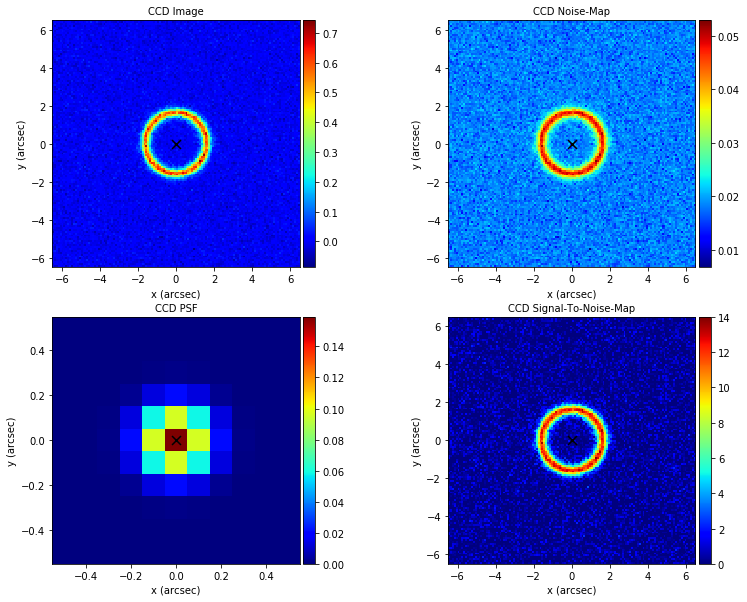

In [4]:
ccd_data = simulate()
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

A GalaxyModel behaves analogously to the Galaxy objects we're now used to. However, whereas for a Galaxy we manually specified the value of every parameter of its light-profiles and mass-profiles, for a GalaxyModel these are inferred by the non-linear search.

Lets model the lens galaxy with an SIS mass profile (which is what it was simulated with).

In [5]:
lens_galaxy_model = gm.GalaxyModel(mass=mp.SphericalIsothermal)

Lets model the source galaxy with a spherical exponential light profile (again, what it was simulated with).

In [6]:
source_galaxy_model = gm.GalaxyModel(light=lp.SphericalExponential)

A phase takes our galaxy models and fits their parameters via a non-linear search (in this case, MultiNest). In this example, we have a lens-plane and source-plane, so we use a LensSourcePlanePhase.

(Just like we could give profiles descriptive names, like 'light', 'bulge' and 'disk', we can do the exact same thing with galaxies. This is very good practise - as once we start using complex lens models, you could potentially have a lot of galaxies - and this is the best way to keep track of them!)

(also, just ignore the 'dict' - its necessary syntax but not something you need to concern yourself with)

In [7]:
phase = ph.LensSourcePlanePhase(phase_name='1_non_linear_search', 
                                lens_galaxies=dict(lens_galaxy=lens_galaxy_model),
                                source_galaxies=dict(source_galaxy=source_galaxy_model),
                                optimizer_class=non_linear.MultiNest)

To run the phase, we simply pass it the image data we want to fit, and the non-linear search begins! As the phase runs, a logger will show you the parameters of the best-fit model.

In [10]:
print('MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/1_non_linear_search'
      'folder for live output of the results, images and lens model.'
      'This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!')
results = phase.run(data=ccd_data)
print('MultiNest has finished run - you may now continue the notebook.')

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/1_non_linear_searchfolder for live output of the results, images and lens model.This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!


/home/jammy/PycharmProjects/VirtualEnvs/PyAutoLens/lib/python3.6/site-packages/getdist/chains.py:1022: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  weights = np.hstack((chain.weights for chain in self.chains))
/home/jammy/PycharmProjects/VirtualEnvs/PyAutoLens/lib/python3.6/site-packages/getdist/chains.py:1023: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  loglikes = np.hstack((chain.loglikes for chain in self.chains))
/home/jammy/PycharmProjects/VirtualEnvs/PyAutoLens/lib/python3.6/site-packages/getdist/chains.py:1024: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as 

/home/jammy/PycharmProjects/PyAutoLens/workspace/howtolens/chapter_2_lens_modeling//output//1_non_linear_search/optimizer/multinest.txt
Removed no burn in


MultiNest has finished run - you may now continue the notebook.


Now this has run you should checkout the 'AutoLens/workspace/howtolens/chapter_2_lens_modeling/output' folder. This is where the results of the phase are written to your hard-disk (in the '1_non_linear_search' folder). 

When its completed, images and output will also appear in this folder, meaning that you don't need to keep running  python code to see the results.

The best-fit solution (i.e. the highest likelihood) is stored in the 'results', which we can plot as per usual.

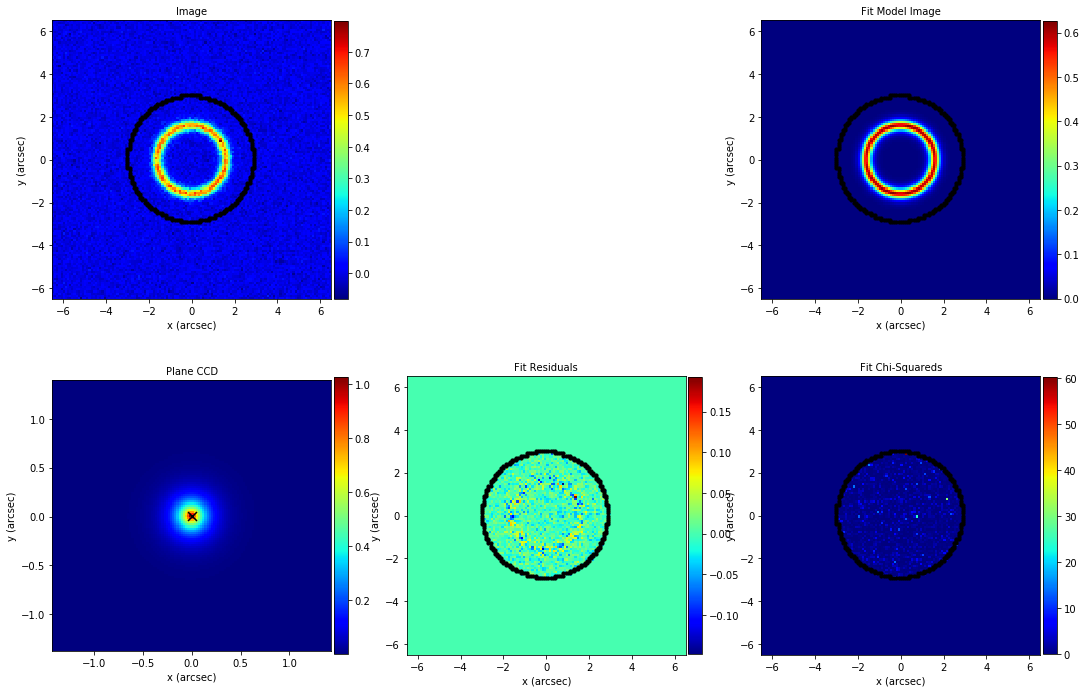

In [10]:
lens_fit_plotters.plot_fit_subplot(fit=results.most_likely_fit)

The fit looks good, and we've therefore found a model pretty close to the one we simulated the image with (you can confirm this yourself if you want, by comparing the inferred parameters to those found in the simulate function above).

And with that, we're done - you've successfully modeled your first strong lens with PyAutoLens! Before moving onto the next tutorial, I want you to think about the following:

1) a non-linear search is often said to search a 'non-linear parameter-space' - why is the term parameter-space used?

2) Why is this parameter space 'non-linear'?

3) Initially, the non-linear search randomly guesses the values of the parameters. However, it shouldn't 'know' what reasonable values for a parameter are. For example, it doesn't know that a reasonable Einstein radius is between 0.0" and 4.0"). How does it know what are reasonable values of parameters to guess?